<a href="https://colab.research.google.com/github/LeoDalcegio/SMS-Spam-Text-Classification/blob/main/SMS_Spam_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the libraries

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

## Get data files

In [ ]:
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

--2021-06-05 17:29:57--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.04s   

2021-06-05 17:29:58 (9.07 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2021-06-05 17:29:58--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==========

In [ ]:
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

## Read files

In [ ]:
train_data = pd.read_csv("train-data.tsv", sep='\t', header=None)
test_data = pd.read_csv("valid-data.tsv", sep='\t', header=None)

print(train_data)

In [ ]:
train_data[0] = train_data[0].astype("category") # cast the pandas object to category type
train_data[0] = train_data[0].cat.codes # ham becomes "0" and "spam" becomes "1"

test_data[0] = test_data[0].astype("category")
test_data[0] = test_data[0].cat.codes


In [ ]:
# separates the data into "label" and "data"

train_labels = train_data[0]
train_data = train_data[1]

test_labels = test_data[0]
test_data = test_data[1]

## Tokenize text

#### TextVectorization
Text vectorization layer, it transforms a batch of strings (one sample = one string) into either a list of token indices or a dense representation.

The processing of each sample contains the following steps:
1. standardize each sample (usually lowercasing + punctuation stripping) .
2. split each sample into substrings (usually words) .
3. recombine substrings into tokens (usually ngrams).
4. index tokens (associate a unique int value with each token) .
5.transform each sample using this index, either into a vector of ints or a dense float vector.

#### adapt
Analyzes the dataset, determines the frequency of individual string values, and creates a "vocabulary" from them

https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee

In [ ]:
max_len = 250

train_data = np.array(train_data)

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
 output_mode='int',
 output_sequence_length=max_len)

encoder.adapt(train_data)

['', '[UNK]', 'to', 'i', 'you', 'a', 'the', 'u', 'and', 'in', 'is', 'me', 'my', 'for', 'your', 'of', 'it', 'call', 'have', 'on', 'that', 'are', 'now', 'im', '2', 'not', 'but', 'so', 'at', 'or', 'do', 'can', 'with', 'be', 'will', 'if', 'get', 'ur', 'just', 'we', 'this', 'no', 'its', 'up', 'go', '4', 'ok', 'dont', 'ltgt', 'free', 'when', 'out', 'how', 'all', 'what', 'from', 'know', 'like', 'got', 'then', 'come', 'good', 'ill', 'time', 'am', 'was', 'only', 'day', 'he', 'love', 'send', 'there', 'as', 'want', 'text', 'going', 'by', 'ü', 'one', 'about', 'need', 'txt', 'lor', 'still', 'our', 'see', 'n', 'r', 'home', 'stop', 'sorry', 'reply', 'back', 'today', 'tell', 'she', 'new', 'been', 'mobile', 'later', 'take', 'hi', 'da', 'her', 'they', 'well', 'think', 'night', 'has', 'any', 'please', 'much', 'cant', 'week', 'dear', 'an', 'happy', 'some', 'pls', 'hey', 'did', 'phone', 'oh', 'who', 'too', 'here', 'make', 'great', 'where', 'way', 'him', 'work', 'tomorrow', 'd', 'more', 'hope', 'had', 'say'

## Create the model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Fit the model

In [ ]:
history = model.fit(train_data, train_labels, validation_data=(test_data,test_labels), epochs=10)

Epoch 1/10
131/131 [==============================] - 67s 429ms/step - loss: 0.6238 - accuracy: 0.8660 - val_loss: 0.4965 - val_accuracy: 0.8657
Epoch 2/10
131/131 [==============================] - 54s 409ms/step - loss: 0.3707 - accuracy: 0.8660 - val_loss: 0.2304 - val_accuracy: 0.8657
Epoch 3/10
131/131 [==============================] - 50s 385ms/step - loss: 0.1484 - accuracy: 0.9292 - val_loss: 0.1122 - val_accuracy: 0.9756
Epoch 4/10
131/131 [==============================] - 51s 390ms/step - loss: 0.0738 - accuracy: 0.9840 - val_loss: 0.0767 - val_accuracy: 0.9784
Epoch 5/10
131/131 [==============================] - 51s 389ms/step - loss: 0.0455 - accuracy: 0.9897 - val_loss: 0.0705 - val_accuracy: 0.9770
Epoch 6/10
131/131 [==============================] - 51s 390ms/step - loss: 0.0308 - accuracy: 0.9935 - val_loss: 0.0640 - val_accuracy: 0.9806
Epoch 7/10
131/131 [==============================] - 51s 386ms/step - loss: 0.0217 - accuracy: 0.9962 - val_loss: 0.0655 - val_ac

## Plot model accuracy

In [ ]:
print(history.history)

{'loss': [0.6237601637840271, 0.37067514657974243, 0.14835473895072937, 0.07375191897153854, 0.04549238830804825, 0.03081873059272766, 0.021742157638072968, 0.01581205241382122, 0.01218167319893837, 0.00955093652009964], 'accuracy': [0.8659966588020325, 0.8659966588020325, 0.9291696548461914, 0.9839674830436707, 0.9897104501724243, 0.9935390949249268, 0.9961713552474976, 0.997367799282074, 0.9980856776237488, 0.9988035559654236], 'val_loss': [0.49646779894828796, 0.23044419288635254, 0.11220762878656387, 0.07666667550802231, 0.0705350935459137, 0.06398852914571762, 0.0654582679271698, 0.06382957100868225, 0.06444244086742401, 0.06711681187152863], 'val_accuracy': [0.8656609058380127, 0.8656609058380127, 0.9755747318267822, 0.9784482717514038, 0.977011501789093, 0.9806034564971924, 0.9798850417137146, 0.9806034564971924, 0.9813218116760254, 0.9798850417137146]}


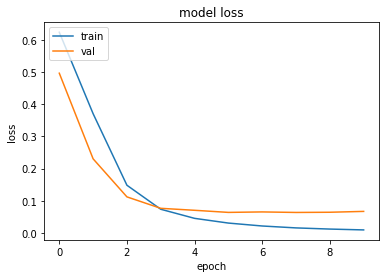

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Function to predict messages based on model

In [ ]:
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  prediction = model.predict(np.array([pred_text]))
  if prediction[0] >= 0.0 :
      prediction_list = [prediction[0], "spam"]
  else : 
      prediction_list = [prediction[0], "ham"]


  return (prediction_list)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[array([-5.661249], dtype=float32), 'ham']


## Testing the model

In [ ]:
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

You passed the challenge. Great job!
